# Heart Disease Prediction using Apache Spark RDDs
## Advanced Implementation - Graduate Level

**Team:** Omar Younis & Tien Duong

**Course:** CPSC 531 - Advanced Database Systems

**Approach:** RDD-focused implementation demonstrating deep Spark internals

---

## Project Overview

This notebook demonstrates implements a heart disease prediction model using:
- **RDD programming** (not DataFrame shortcuts)
- **Manual feature engineering** (not VectorAssembler)
- **Custom ML algorithm** (gradient descent from scratch)
- **Explicit partition control** and optimization
- **Performance analysis** and tuning

This aligns with class materials.

## Table of Contents

1. Advanced Spark Configuration
2. Data Loading with RDDs
3. Data Augmentation & Partitioning
4. Exploratory Data Analysis
5. Manual Feature Engineering
6. Partitioning & Shuffle Analysis
7. DAG & Lineage Analysis
8. Custom Logistic Regression
9. Model Evaluation
10. Performance Tuning
11. RDD vs DataFrame Comparison
12. Conclusions & Lessons Learned

---

# Advanced Spark Setup & Configuration

**Todo:**
- Install PySpark
- Configure SparkContext with explicit settings
- Control partitioning, memory, and serialization
- Understand cluster manager modes (Local, Standalone, YARN, Mesos, Kubernetes)
- Verify setup and configuration

In [ ]:
# Install PySpark
!pip install pyspark

print("PySpark installed successfully!")

PySpark installed successfully!


In [ ]:
import os

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("ADVANCED SPARK CONFIGURATION")
print("="*70)

# Create custom config
conf = SparkConf() \
  .setAppName("Heart Disease Predictor - RDD version") \
  .setMaster("local[*]") \
  .set("spark.default.parallelism", "8") \
  .set("spark.sql.shuffle.partitions", "8") \
  .set("spark.executor.memory", "4g") \
  .set("spark.driver.memory", "4g") \
  .set("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
  .set("spark.ui.showConsoleProgress", "true") \
  .set("spark.sql.adaptive.enabled", "false")

# Create SparkContext (low-level) and SparkSession (high-level)
# NOTE: Need SC for RDD, Session for Utilities
try:
  sc = SparkContext.getOrCreate(conf=conf)
  spark = SparkSession(sc)
  print("SparkContext created successfully!")
  print(f"Spark Version: {sc.version}")
  print(f"Master: {sc.master}")
  print(f"App Name: {sc.appName}")
  print(f"Default Parallelism: {sc.defaultParallelism}")

except Exception as e:
  print(f"Error creating SparkContext: {e}")
  # If context already exists, use it:
  sc = SparkContext.getOrCreate()
  spark = SparkSession(sc)
  print("Using existing SparkContext")

print("="*70)

ADVANCED SPARK CONFIGURATION
SparkContext created successfully!
Spark Version: 3.5.1
Master: local[*]
App Name: Heart Disease Predictor - RDD version
Default Parallelism: 8


In [ ]:
print("\nCONFIGURATION EXPLANATION:")
print("="*70)

config_explanations = {
    "spark.default.parallelism": "Number of partitions for RDDs without explicit partitioning",
    "spark.sql.shuffle.partitions": "Partitions created during shuffle operations",
    "spark.executor.memory": "Memory available to each executor",
    "spark.driver.memory": "Memory available to driver program (our notebook)",
    "spark.serializer": "Kryo is faster than Java serialization",
    "spark.sql.adaptive.enabled": "Disable to see raw partition behavior"
}

for key, explanation in config_explanations.items():
  print(f"  • {key}")
  print(f"    → {explanation}\n")
  print("-"*70)


CONFIGURATION EXPLANATION:
  • spark.default.parallelism
    → Number of partitions for RDDs without explicit partitioning

----------------------------------------------------------------------
  • spark.sql.shuffle.partitions
    → Partitions created during shuffle operations

----------------------------------------------------------------------
  • spark.executor.memory
    → Memory available to each executor

----------------------------------------------------------------------
  • spark.driver.memory
    → Memory available to driver program (our notebook)

----------------------------------------------------------------------
  • spark.serializer
    → Kryo is faster than Java serialization

----------------------------------------------------------------------
  • spark.sql.adaptive.enabled
    → Disable to see raw partition behavior

----------------------------------------------------------------------


In [ ]:
print(f"\nSPARK UI:")
print(f"   Access Spark UI at: http://localhost:4040")
print(f"   (Note: May not work in Colab, but works in local Jupyter)")
print(f"   Use this to visualize DAGs, stages, and tasks!")


SPARK UI:
   Access Spark UI at: http://localhost:4040
   (Note: May not work in Colab, but works in local Jupyter)
   Use this to visualize DAGs, stages, and tasks!


# Part 2: Data Loading with RDDs & Partition Analysis

**Todo:**
- Load CSV as text file using `sc.textFile()` (not DataFrame API)
- Manually parse CSV lines (no automatic schema inference)
- Augment data from 300 → 30,000 rows for realistic parallel processing
- Explicitly control partitioning with `.repartition()`
- Analyze partition distribution with `mapPartitionsWithIndex()`
- Visualize RDD lineage (execution plan)

In [ ]:
# from google.colab import files

# print("Please upload your heart.csv file...")
# uploaded = files.upload()

# # Get filename
# filename = list(uploaded.keys())[0]
# print(f"Uploaded file: {filename}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

filepath = '/content/drive/MyDrive/heart.csv'
print(f"Dataset path: {filepath}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset path: /content/drive/MyDrive/heart.csv


In [ ]:
print("="*70)
print("LOADING DATA AS RDD")
print("="*70)

# Load as text file - each line is an element
raw_rdd = sc.textFile(filepath)

print(f"Loaded RDD from CSV")
print(f"Number of partitions: {raw_rdd.getNumPartitions()}")
print(f"Total lines: {raw_rdd.count()}")

# Look at first few lines
print("\nFirst 3 lines:")
for i, line in enumerate(raw_rdd.take(3)):
  print(f"  {i}: {line[:80]}...")  # Truncate for readability

print("="*70)

LOADING DATA AS RDD
Loaded RDD from CSV
Number of partitions: 2
Total lines: 1026

First 3 lines:
  0: age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target...
  1: 52,1,0,125,212,0,1,168,0,1,2,2,3,0...
  2: 53,1,0,140,203,1,0,155,1,3.1,0,0,3,0...


In [ ]:
print("\n" + "="*70)
print("MANUAL CSV PARSING")
print("="*70)

# Extract header
header = raw_rdd.first()
print(f"Header: {header}\n")

# Parse the rest (Narrow Transformation)
def parse_line(line):
  """Convert CSV line to a list of values"""
  return line.split(',')

# Filter headers out and parse
data_rdd = raw_rdd.filter(lambda line: line != header).map(parse_line)

# Convert numeric columns (except first row)
def convert_types(row):
  """Convert string values to appropriate types"""
  try:
    # All columns are numeric in heart disease dataset
    return [float(x) for x in row]
  except:
    return None

parsed_rdd = data_rdd.map(convert_types) \
                      .filter(lambda x: x is not None) # Remove any none parsed data

# Cache this RDD since we'll use it multiple times
parsed_rdd = parsed_rdd.cache()

# Count to materialize the cache
original_count = parsed_rdd.count()

print(f"Parsed {original_count} rows")
print(f"Sample row: {parsed_rdd.first()}")
print(f"Number of features: {len(parsed_rdd.first())}")
print("="*70)


MANUAL CSV PARSING
Header: age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target

Parsed 1025 rows
Sample row: [52.0, 1.0, 0.0, 125.0, 212.0, 0.0, 1.0, 168.0, 0.0, 1.0, 2.0, 2.0, 3.0, 0.0]
Number of features: 14


In [ ]:
print("\n" + "="*70)
print("DATA AUGMENTATION FOR PARTITIONING DEMO")
print("="*70)

import random

def augment_row(row, replica_id):
    """
    Create synthetic variation of a row by adding small random noise.
    This simulates having more real data while maintaining distribution.
    """
    random.seed(hash((tuple(row), replica_id)))  # Deterministic but varied

    # Add small noise to features (all except last column which is target)
    augmented = []
    for i, value in enumerate(row[:-1]):
        # Add ±5% noise to numeric features
        noise = random.uniform(-0.05, 0.05) * value
        augmented.append(value + noise)

    # Keep original target class (last column)
    augmented.append(row[-1])

    return augmented

# Replicate each row 100 times with variations
REPLICAS = 100

augmented_rdd = parsed_rdd.flatMap(
    lambda row: [augment_row(row, i) for i in range(REPLICAS)]
)

# Cache the augmented dataset
augmented_rdd = augmented_rdd.cache()
augmented_count = augmented_rdd.count()

print(f"Original rows: {original_count}")
print(f"Augmented rows: {augmented_count} ({REPLICAS}x replication)")
print(f"Sample augmented row: {augmented_rdd.first()}")
print("\nThis larger dataset better demonstrates Spark's parallel processing!")
print("="*70)


DATA AUGMENTATION FOR PARTITIONING DEMO
Original rows: 1025
Augmented rows: 102500 (100x replication)
Sample augmented row: [52.57049293713712, 0.9807634400273716, 0.0, 121.6324185701609, 203.48653239634066, 0.0, 1.0064031548601513, 176.26154129997624, 0.0, 1.0107447551046933, 2.0253447264559474, 1.9189825344264047, 2.912049082645305, 0.0]

This larger dataset better demonstrates Spark's parallel processing!


In [ ]:
print("\n" + "="*70)
print("EXPLICIT REPARTITIONING")
print("="*70)

# Check current partitions
current_partitions = augmented_rdd.getNumPartitions()
print(f"Current partitions: {current_partitions}")

# Repartition to control parallelism
TARGET_PARTITIONS = 16

repartitioned_rdd = augmented_rdd.repartition(TARGET_PARTITIONS).cache()
repartitioned_rdd.count()   # Materialize

print(f"Repartitioned to: {TARGET_PARTITIONS} partitions")
print(f"   → Spark can now process {TARGET_PARTITIONS} chunks in parallel")
print(f"   → Each partition will have ~{augmented_count // TARGET_PARTITIONS} rows")

# This is the working dataset going forward
working_rdd = repartitioned_rdd

print("="*70)


EXPLICIT REPARTITIONING
Current partitions: 2
Repartitioned to: 16 partitions
   → Spark can now process 16 chunks in parallel
   → Each partition will have ~6406 rows


In [ ]:
print("\n" + "="*70)
print("PARTITION ANALYSIS")
print("="*70)

def analyze_partition(partition_index, iterator):
  """
  Analyze a single partition.
  This function runs on the executor for that partition.
  """
  items = list(iterator)
  count = len(items)

  if count > 0:
    # Get class distribution (assuming last column is target)
    classes = [row[-1] for row in items]
    class_0 = classes.count(0.0)
    class_1 = classes.count(1.0)

    yield (partition_index, {
        'count': count,
        'class_0': class_0,
        'class_1': class_1,
        'balance': class_1 / count if count > 0 else 0
    })
  else:
    yield (partition_index, {'count': 0})

# Use mapPartitionsWithIndex to analyze each partition
partition_stats = working_rdd.mapPartitionsWithIndex(analyze_partition).collect()

print(f"\nPartition Distribution (showing first 10):")
print(f"{'Partition':<12} {'Rows':<10} {'Class 0':<10} {'Class 1':<10} {'Balance':<10}")
print("-"*60)

for partition_id, stats in sorted(partition_stats[:10]):
  if stats['count'] > 0:
    print(f"{partition_id:<12} {stats['count']:<10} {stats['class_0']:<10} "
          f"{stats['class_1']:<10} {stats['balance']:.2%}")
  else:
    print(f"{partition_id:<12} {'EMPTY':<10}")

print("-"*60)
print(f"\nNotice: Partitions have roughly equal row counts (good!)")
print(f"This is because repartition() uses hash partitioning by default")
print("="*70)


PARTITION ANALYSIS

Partition Distribution (showing first 10):
Partition    Rows       Class 0    Class 1    Balance   
------------------------------------------------------------
0            6400       3180       3220       50.31%
1            6400       3180       3220       50.31%
2            6400       3120       3280       51.25%
3            6400       3120       3280       51.25%
4            6410       3100       3310       51.64%
5            6410       3100       3310       51.64%
6            6410       3040       3370       52.57%
7            6410       3040       3370       52.57%
8            6410       3140       3270       51.01%
9            6410       3140       3270       51.01%
------------------------------------------------------------

Notice: Partitions have roughly equal row counts (good!)
This is because repartition() uses hash partitioning by default


In [ ]:
print("\n" + "="*70)
print("RDD LINEAGE (Execution Plan)")
print("="*70)

# Show the lineage (what transformations were applied)
lineage = working_rdd.toDebugString().decode('utf-8')

print("Our RDD's lineage:")
print(lineage)

print("\nUnderstanding the lineage:")
print("  • Each line shows a transformation")
print("  • Indentation shows dependencies")
print("  • ShuffledRDD appears after repartition (wide transformation)")
print("  • This is the DAG that Spark will execute!")
print("="*70)


RDD LINEAGE (Execution Plan)
Our RDD's lineage:
(16) MapPartitionsRDD[118] at coalesce at NativeMethodAccessorImpl.java:0 [Memory Serialized 1x Replicated]
 |        CachedPartitions: 16; MemorySize: 9.2 MiB; DiskSize: 0.0 B
 |   CoalescedRDD[117] at coalesce at NativeMethodAccessorImpl.java:0 [Memory Serialized 1x Replicated]
 |   ShuffledRDD[116] at coalesce at NativeMethodAccessorImpl.java:0 [Memory Serialized 1x Replicated]
 +-(2) MapPartitionsRDD[115] at coalesce at NativeMethodAccessorImpl.java:0 [Memory Serialized 1x Replicated]
    |  PythonRDD[114] at RDD at PythonRDD.scala:53 [Memory Serialized 1x Replicated]
    |  PythonRDD[111] at RDD at PythonRDD.scala:53 [Memory Serialized 1x Replicated]
    |      CachedPartitions: 2; MemorySize: 9.1 MiB; DiskSize: 0.0 B
    |  PythonRDD[107] at RDD at PythonRDD.scala:53 [Memory Serialized 1x Replicated]
    |      CachedPartitions: 2; MemorySize: 37.6 KiB; DiskSize: 0.0 B
    |  /content/drive/MyDrive/heart.csv MapPartitionsRDD[103] a

# Part 3: Exploratory Data Analysis Using RDD Transformations

**Todo:**
- Calculate mean and standard deviation using `combineByKey()` (wide transformation)
- Calculate min/max using `reduceByKey()` (wide transformation)
- Analyze target variable distribution with `countByValue()` (action)
- Calculate feature correlations manually
- **All without using DataFrame's `.describe()` method!**

In [ ]:
print("="*70)
print("EXPLORATORY DATA ANALYSIS WITH RDDS")
print("="*70)

# Define feature names (from dataset documentation)
FEATURE_NAMES = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

NUM_FEATURES = len(FEATURE_NAMES)
print(f"Dataset has {NUM_FEATURES} columns:")
for i, name in enumerate(FEATURE_NAMES):
  print(f"  {i}: {name}")

print("="*70)

EXPLORATORY DATA ANALYSIS WITH RDDS
Dataset has 14 columns:
  0: age
  1: sex
  2: cp
  3: trestbps
  4: chol
  5: fbs
  6: restecg
  7: thalach
  8: exang
  9: oldpeak
  10: slope
  11: ca
  12: thal
  13: target


In [ ]:
print("\n" + "="*70)
print("CALCULATING STATISTICS WITH combineByKey")
print("="*70)

def to_feature_pairs(row):
  """
  Convert a row into multiple (feature_index, value) pairs.
  This is a flatMap operation - one row becomes many pairs.
  """
  for feature_idx in range(len(row)):
    yield (feature_idx, row[feature_idx])

# Create (feature_index, value) RDD
feature_value_rdd = working_rdd.flatMap(to_feature_pairs)

print(f"Created feature-value pairs")
print(f"   Example: {feature_value_rdd.take(3)}")


# Use combineByKey to calculate mean and standard deviation
# This is a WIDE transformation (requires shuffle)

def create_combiner(value):
  """
  Create initial accumulator for a new key.
  Returns: (sum, sum_of_squares, count)
  """
  return (value, value * value, 1)

def merge_value(accumulator, value):
  """
  Add a new value to an existing accumulator.
  """
  sum_val, sum_sq, count = accumulator
  return (sum_val + value, sum_sq + value * value, count + 1)

def merge_combiners(acc1, acc2):
  """
  Merge two accumulators (happens during shuffle).
  """
  return (
      acc1[0] + acc2[0],  # sum
      acc1[1] + acc2[1],  # sum of squares
      acc1[2] + acc2[2]   # count
  )

# Apply combineByKey - this will shuffle data!
combined_stats = feature_value_rdd.combineByKey(
    create_combiner,
    merge_value,
    merge_combiners
)

print(f"\nApplied combineByKey (WIDE transformation - requires shuffle)")
print(f"   This grouped values by feature index across all partitions")

def calculate_final_stats(item):
  """Calculate mean and standard deviation from accumulated values"""
  feature_idx, (sum_val, sum_sq, count) = item

  mean = sum_val / count
  variance = (sum_sq / count) - (mean ** 2)
  stddev = variance ** 0.5 if variance > 0 else 0.0

  return {
      'feature_idx': feature_idx,
      'feature_name': FEATURE_NAMES[feature_idx],
      'mean': mean,
      'stddev': stddev,
      'count': count
  }

feature_stats_rdd = combined_stats.map(calculate_final_stats)
feature_stats = sorted(feature_stats_rdd.collect(), key=lambda x: x['feature_idx'])

print("\nFeature Statistics:")
print(f"{'Feature':<15} {'Mean':<12} {'Std Dev':<12} {'Count':<12}")
print("-"*60)

for stats in feature_stats:
    print(f"{stats['feature_name']:<15} {stats['mean']:<12.2f} "
          f"{stats['stddev']:<12.2f} {stats['count']:<12.0f}")

print("-"*60)
print("\nWe just performed a distributed aggregation across all partitions!")
print("="*70)


CALCULATING STATISTICS WITH combineByKey
Created feature-value pairs
   Example: [(0, 53.43074316329033), (1, 1.017771302849513), (2, 0.0)]

Applied combineByKey (WIDE transformation - requires shuffle)
   This grouped values by feature index across all partitions

Feature Statistics:
Feature         Mean         Std Dev      Count       
------------------------------------------------------------
age             54.42        9.19         102500      
sex             0.70         0.46         102500      
cp              0.94         1.03         102500      
trestbps        131.61       17.92        102500      
chol            245.95       52.06        102500      
fbs             0.15         0.36         102500      
restecg         0.53         0.53         102500      
thalach         149.14       23.43        102500      
exang           0.34         0.47         102500      
oldpeak         1.07         1.18         102500      
slope           1.39         0.62         10250

In [ ]:
print("\n" + "="*70)
print("CALCULATING MIN/MAX WITH reduceByKey")
print("="*70)

# Create (feature_index, value) pairs again
feature_value_rdd = working_rdd.flatMap(to_feature_pairs)

# Calculate min using reduceByKey (WIDE transformation)
min_by_feature = feature_value_rdd.reduceByKey(lambda a, b: min(a, b))

# Calculate max using reduceByKey (WIDE transformation)
max_by_feature = feature_value_rdd.reduceByKey(lambda a, b: max(a, b))

# Collect results
min_values = sorted(min_by_feature.collect())
max_values = sorted(max_by_feature.collect())

print("\nMin/Max Values:")
print(f"{'Feature':<15} {'Min':<12} {'Max':<12} {'Range':<12}")
print("-"*60)

for (idx, min_val), (_, max_val) in zip(min_values, max_values):
    feature_name = FEATURE_NAMES[idx]
    range_val = max_val - min_val
    print(f"{feature_name:<15} {min_val:<12.2f} {max_val:<12.2f} {range_val:<12.2f}")

print("-"*60)
print("\nreduceByKey vs groupByKey:")
print("  • reduceByKey: Combines values BEFORE shuffle (efficient)")
print("  • groupByKey: Shuffles all values first (inefficient)")
print("  • Always prefer reduceByKey when possible!")
print("="*70)


CALCULATING MIN/MAX WITH reduceByKey

Min/Max Values:
Feature         Min          Max          Range       
------------------------------------------------------------
age             27.60        80.79        53.19       
sex             0.00         1.05         1.05        
cp              0.00         3.15         3.15        
trestbps        89.34        209.82       120.48      
chol            119.78       592.08       472.29      
fbs             0.00         1.05         1.05        
restecg         0.00         2.10         2.10        
thalach         67.66        212.02       144.36      
exang           0.00         1.05         1.05        
oldpeak         0.00         6.50         6.50        
slope           0.00         2.10         2.10        
ca              0.00         4.20         4.20        
thal            0.00         3.15         3.15        
target          0.00         1.00         1.00        
-----------------------------------------------------------

In [ ]:
print("\n" + "="*70)
print("CLASS DISTRIBUTION")
print("="*70)

# Extract target variable (last column)
target_rdd = working_rdd.map(lambda row: row[-1])

# countByValue triggers computation
class_distribution = target_rdd.countByValue()

print("\nTarget Class Distribution:")
for class_label, count in sorted(class_distribution.items()):
  percentage = (count / target_rdd.count()) * 100
  print(f"  Class {int(class_label)}: {count:,} ({percentage:.1f}%)")

print(f"\nDataset is {'balanced' if abs(percentage - 50) < 10 else 'imbalanced'}")
print("="*70)


CLASS DISTRIBUTION

Target Class Distribution:
  Class 0: 49,900 (48.7%)
  Class 1: 52,600 (51.3%)

Dataset is balanced


In [ ]:
print("\n" + "="*70)
print("FEATURE CORRELATION ANALYSIS")
print("="*70)

# Calculate correlation between age and target
# This shows how to do statistical operations with RDDs

def calculate_correlation(rdd, feature1_idx, feature2_idx):
  """
  Calculate Pearson correlation between two features using RDD operations.
  """
  # Extract feature pairs
  pairs = rdd.map(lambda row: (row[feature1_idx], row[feature2_idx]))

  # Calculate means
  n = pairs.count()
  sum1 = pairs.map(lambda x: x[0]).reduce(lambda a, b: a + b)
  sum2 = pairs.map(lambda x: x[1]).reduce(lambda a, b: a + b)
  mean1 = sum1 / n
  mean2 = sum2 / n

  # Calculate correlation components
  def calc_components(pair):
    x, y = pair
    return (
        (x - mean1) * (y - mean2),    # covariance component
        (x - mean1) ** 2,             # variance of x
        (y - mean2) ** 2              # variance of y
    )

  components = pairs.map(calc_components).reduce(
      lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2])
  )

  cov, var1, var2 = components

  correlation = cov / ((var1 * var2) ** 0.5) if var1 > 0 and var2 > 0 else 0
  return correlation

# Calculate correlation between a few important features and target
important_features = [
    ('age', 0, 13),
    ('thalach', 7, 13),
    ('oldpeak', 9, 13)
]

print("\nCorrelation with Target:")
print(f"{'Feature':<15} {'Correlation':<15}")
print("-"*30)

for feature_name, feature_idx, target_idx in important_features:
  corr = calculate_correlation(working_rdd, feature_idx, target_idx)
  print(f"{feature_name:<15} {corr:<15.3f}")


print("-"*30)
print("\nHigh absolute correlation → strong relationship with target")
print("="*70)


FEATURE CORRELATION ANALYSIS

Correlation with Target:
Feature         Correlation    
------------------------------
age             -0.225         
thalach         0.416          
oldpeak         -0.438         
------------------------------

High absolute correlation → strong relationship with target


# Part 4: Manual Feature Engineering with RDDs

**Todo:**
- Separate features and target variables manually
- Calculate statistics (mean, stddev) using `aggregateByKey()`
- Standardize features using broadcast variables (efficient!)
- Split data into train/test with stratification
- **All without VectorAssembler or StandardScaler from MLlib!**

In [ ]:
print("="*70)
print("FEATURE ENGINEERING WITH RDDS")
print("="*70)

def separate_features_target(row):
  """
  Separate features from target label.
  Returns: (features_list, target_value)
  """
  features = row[:-1]   # All columns except last
  target = row[-1]      # Last column
  return (features, target)

# Apply separation
feature_target_rdd = working_rdd.map(separate_features_target).cache()

print(f"Separated features and target")
print(f"   Sample: {feature_target_rdd.first()}")
print(f"   Number of features: {len(feature_target_rdd.first()[0])}")
print("="*70)

FEATURE ENGINEERING WITH RDDS
Separated features and target
   Sample: ([53.43074316329033, 1.017771302849513, 0.0, 136.60718019809042, 201.7889192805588, 1.038759099011234, 0.0, 155.1794217012177, 1.0073707420131037, 3.039702051099781, 0.0, 0.0, 3.083847917195238], 0.0)
   Number of features: 13


In [ ]:
print("\n" + "="*70)
print("CALCULATE STATISTICS FOR STANDARDIZATION")
print("="*70)

# Need mean and standard deviation for each feature
# Using Sinlge pass with aggregateByKey

def calculate_feature_stats(rdd):
  """
  Calculate mean and stddev for each feature position.
  Results dictionary: {feature_idx: {'mean': ..., 'std': ...}}
  """
  # Convert to (feature_idx, value) pairs
  feature_pairs = rdd.flatMap(
      lambda row: [(i, val) for i, val in enumerate(row[0])]    # row[0] is feature
  )

  # Use aggregateByKey for efficient computation
  # Initial value: (sum, sum_of_squares, count)
  def seq_op(acc, value):
    return (acc[0] + value, acc[1] + value**2, acc[2] + 1)

  def comb_op(acc1, acc2):
    return (acc1[0] + acc2[0], acc1[1] + acc2[1], acc1[2] + acc2[2])

  stats = feature_pairs.aggregateByKey(
      (0.0, 0.0, 0),  # Initial: (sum, sum_sq, count)
      seq_op,
      comb_op
  )

  # Calculate mean and std
  def finalize_stats(item):
    idx, (sum_val, sum_sq, count) = item
    mean = sum_val / count
    variance = (sum_sq / count) - (mean ** 2)
    stddev = variance ** 0.5 if variance > 0 else 1e-8  # Avoid division by zero
    return (idx, {'mean': mean, 'stddev': stddev})

  return dict(stats.map(finalize_stats).collect())

stats_dict = calculate_feature_stats(feature_target_rdd)

print("Calculated statistics for standardization")
print("\nSample statistics (first 5 features):")
print(f"{'Feature':<15} {'Mean':<12} {'Std Dev':<12}")
print("-"*40)

for i in range(min(5, len(stats_dict))):
    feature_name = FEATURE_NAMES[i]
    print(f"{feature_name:<15} {stats_dict[i]['mean']:<12.2f} "
          f"{stats_dict[i]['stddev']:<12.2f}")

print("-"*40)
print("="*70)


CALCULATE STATISTICS FOR STANDARDIZATION
Calculated statistics for standardization

Sample statistics (first 5 features):
Feature         Mean         Std Dev     
----------------------------------------
age             54.42        9.19        
sex             0.70         0.46        
cp              0.94         1.03        
trestbps        131.61       17.92       
chol            245.95       52.06       
----------------------------------------


In [ ]:
print("\n" + "="*70)
print("STANDARDIZATION WITH BROADCAST VARIABLES")
print("="*70)

# Broadcast statistics to all executors
# This is more efficient than sending stats with every task
stats_broadcast = sc.broadcast(stats_dict)

print(f"Broadcast statistics to all executors")
print(f"   Broadcast value type: {type(stats_broadcast.value)}")
print(f"   This avoids sending {len(stats_dict)} stats with every task!")

def standardize_feature(row):
  """
  Standardize features using broadcasted statistics.
  Formula: z = (x - mean) / stddev
  """
  features, target = row
  stats = stats_broadcast.value   # Access broadcasted variable

  standardized = []
  for i, value in enumerate(features):
    mean = stats[i]['mean']
    std = stats[i]['stddev']
    z_score = (value - mean) / std
    standardized.append(z_score)

  return (standardized, target)

# Apply standardization (Narrow Transformation)
standardized_rdd = feature_target_rdd.map(standardize_feature).cache()

# Materialize to trigger computation
sample_count = standardized_rdd.count()

print(f"\nStandardized {sample_count:,} samples")
print(f"   Before: {feature_target_rdd.first()[0][:3]}")
print(f"   After:  {standardized_rdd.first()[0][:3]}")
print("\nValues are now centered at 0 with std dev of 1")
print("="*70)


STANDARDIZATION WITH BROADCAST VARIABLES
Broadcast statistics to all executors
   Broadcast value type: <class 'dict'>
   This avoids sending 13 stats with every task!

Standardized 102,500 samples
   Before: [53.43074316329033, 1.017771302849513, 0.0]
   After:  [-0.1075859423235127, 0.6984240730665742, -0.9149202920141206]

Values are now centered at 0 with std dev of 1


In [ ]:
print("\n" + "="*70)
print("STRATIFIED TRAIN/TEST SPLIT")
print("="*70)

# Add a random split key while preserving stratification
import random
random.seed(42)

def add_split_label(row):
  """
  Add train/test label to each row.
  Use random number with fixed seed to be repoducable
  """
  features, target = row
  # Use hash of features for deterministic but random-seeming split
  random.seed(int(hash(tuple(features)) % 1_000_000))
  split = 'train' if random.random() < 0.8 else 'test'
  return (split, (features, target))

# Create splits
split_labeled_rdd = standardized_rdd.map(add_split_label)

# Filter for train and test
train_rdd = split_labeled_rdd.filter(lambda x: x[0] == 'train') \
                             .map(lambda x: x[1]) \
                             .cache()

test_rdd = split_labeled_rdd.filter(lambda x: x[0] == 'test') \
                             .map(lambda x: x[1]) \
                             .cache()

# Count splits
train_count = train_rdd.count()
test_count = test_rdd.count()

print(f"Created train/test split:")
print(f"   Train: {train_count:,} samples ({train_count/(train_count+test_count)*100:.1f}%)")
print(f"   Test:  {test_count:,} samples ({test_count/(train_count+test_count)*100:.1f}%)")

# Verify class balance in splits
train_class_dist = train_rdd.map(lambda x: x[1]).countByValue()
test_class_dist = test_rdd.map(lambda x: x[1]).countByValue()

print(f"\nClass distribution in splits:")
print(f"   Train - Class 0: {train_class_dist.get(0.0, 0):,}, "
      f"Class 1: {train_class_dist.get(1.0, 0):,}")
print(f"   Test  - Class 0: {test_class_dist.get(0.0, 0):,}, "
      f"Class 1: {test_class_dist.get(1.0, 0):,}")

print("="*70)


STRATIFIED TRAIN/TEST SPLIT
Created train/test split:
   Train: 81,594 samples (79.6%)
   Test:  20,906 samples (20.4%)

Class distribution in splits:
   Train - Class 0: 39,845, Class 1: 41,749
   Test  - Class 0: 10,055, Class 1: 10,851


# Part 5: Understanding Partitioning & Shuffle Operations

**Todo:**
- Analyze partition distribution after train/test split
- Compare `groupByKey()` vs `reduceByKey()` (inefficient vs efficient)
- Implement custom partitioner for controlled data placement
- Understand join operations and their shuffle costs
- Visualize data movement during wide transformations

In [ ]:
print("="*70)
print("PARTITION ANALYSIS AFTER SPLIT")
print("="*70)

def analyze_partition_detailed(partition_index, iterator):
  """Detailed partition analysis"""
  items = list(iterator)

  if len(items) == 0:
    return []

  targets = [target for features, target in items]
  class_0 = targets.count(0.0)
  class_1 = targets.count(1.0)

  return [(partition_index, {
      'count': len(items),
      'class_0': class_0,
      'class_1': class_1,
      'first_row': items[0] if items else None
  })]

train_partitions = train_rdd.mapPartitionsWithIndex(analyze_partition_detailed).collect()
test_partitions = test_rdd.mapPartitionsWithIndex(analyze_partition_detailed).collect()

print("\nTrain Partition Distribution:")
print(f"{'Partition':<12} {'Rows':<10} {'Class 0':<10} {'Class 1':<10}")
print("-"*50)
for idx, stats in sorted(train_partitions)[:8]:  # Show first 8
    print(f"{idx:<12} {stats['count']:<10} {stats['class_0']:<10} {stats['class_1']:<10}")
print(f"... ({len(train_partitions)} total partitions)")
print("-"*50)

print(f"\nTrain RDD has {train_rdd.getNumPartitions()} partitions")
print(f"Test RDD has {test_rdd.getNumPartitions()} partitions")
print("="*70)

PARTITION ANALYSIS AFTER SPLIT

Train Partition Distribution:
Partition    Rows       Class 0    Class 1   
--------------------------------------------------
0            5104       2531       2573      
1            5105       2521       2584      
2            5104       2500       2604      
3            5081       2492       2589      
4            5140       2503       2637      
5            5065       2466       2599      
6            5113       2460       2653      
7            5119       2490       2629      
... (16 total partitions)
--------------------------------------------------

Train RDD has 16 partitions
Test RDD has 16 partitions


In [ ]:
print("\n" + "="*70)
print("SHUFFLE DEMONSTRATION: groupByKey vs reduceByKey")
print("="*70)

import time

# Create key-value pairs: (target_class, features)
keyed_train = train_rdd.map(lambda x: (x[1], x[0]))

print("Testing shuffle performance with different operations...")

# Method 1: groupByKey (INEFFICIENT - shuffles all data)
print("\nTesting groupByKey (BAD - shuffles everything):")
start = time.time()
grouped = keyed_train.groupByKey() \
                     .mapValues(lambda features: len(list(features))) \
                     .collect()
groupby_time = time.time() - start
print(f"   Time: {groupby_time:.3f} seconds")
print(f"   Result: {dict(grouped)}")

# Method 2: reduceByKey (EFFICIENT - reduces before shuffle)
print("\nTesting reduceByKey (GOOD - reduces before shuffle):")
start = time.time()
reduced = keyed_train.mapValues(lambda features: 1) \
                     .reduceByKey(lambda a, b: a + b) \
                     .collect()
reduceby_time = time.time() - start
print(f"   Time: {reduceby_time:.3f} seconds")
print(f"   Result: {dict(reduced)}")

# Method 3: aggregateByKey (MOST FLEXIBLE)
print("\nTesting aggregateByKey (BEST - flexible + efficient):")
start = time.time()
aggregated = keyed_train.aggregateByKey(
    0,  # Initial value
    lambda acc, features: acc + 1,  # Add to accumulator
    lambda acc1, acc2: acc1 + acc2  # Merge accumulators
).collect()
aggregate_time = time.time() - start
print(f"   Time: {aggregate_time:.3f} seconds")
print(f"   Result: {dict(aggregated)}")

print("\nPerformance Comparison:")
print(f"   groupByKey:     {groupby_time:.3f}s (baseline)")
print(f"   reduceByKey:    {reduceby_time:.3f}s ({reduceby_time/groupby_time*100:.1f}%)")
print(f"   aggregateByKey: {aggregate_time:.3f}s ({aggregate_time/groupby_time*100:.1f}%)")

print("\nWhy reduceByKey/aggregateByKey are faster:")
print("   • groupByKey: Sends ALL values across network, then groups")
print("   • reduceByKey: Combines values FIRST (locally), then shuffles less data")
print("   • aggregateByKey: Like reduceByKey but more flexible")

print("="*70)


SHUFFLE DEMONSTRATION: groupByKey vs reduceByKey
Testing shuffle performance with different operations...

Testing groupByKey (BAD - shuffles everything):
   Time: 2.424 seconds
   Result: {0.0: 39845, 1.0: 41749}

Testing reduceByKey (GOOD - reduces before shuffle):
   Time: 3.112 seconds
   Result: {0.0: 39845, 1.0: 41749}

Testing aggregateByKey (BEST - flexible + efficient):
   Time: 3.252 seconds
   Result: {0.0: 39845, 1.0: 41749}

Performance Comparison:
   groupByKey:     2.424s (baseline)
   reduceByKey:    3.112s (128.4%)
   aggregateByKey: 3.252s (134.1%)

Why reduceByKey/aggregateByKey are faster:
   • groupByKey: Sends ALL values across network, then groups
   • reduceByKey: Combines values FIRST (locally), then shuffles less data
   • aggregateByKey: Like reduceByKey but more flexible


In [ ]:
print("\n" + "="*70)
print("CUSTOM PARTITIONER FOR TARGET CLASSES")
print("="*70)

# In PySpark, custom partitioning is done via partitionBy() with a partition function
# (The Partitioner class is NOT available in Python API - only in Scala/Java)

# Apply custom partitioning using a lambda function
custom_partitioned = keyed_train.partitionBy(
    numPartitions=4,
    partitionFunc=lambda key: int(key) % 4
).cache()

custom_partitioned.count()  # Materialize

print("Applied custom partitioner (4 partitions)")

# Analyze the custom partitioning
def analyze_custom_partition(idx, iterator):
    items = list(iterator)
    if not items:
        return []

    keys = [key for key, _ in items]
    return [(idx, {
        'count': len(items),
        'class_0': keys.count(0.0),
        'class_1': keys.count(1.0),
        'primary_class': max(set(keys), key=keys.count)
    })]

custom_stats = custom_partitioned.mapPartitionsWithIndex(analyze_custom_partition).collect()

print("\nCustom Partition Distribution:")
print(f"{'Partition':<12} {'Total':<10} {'Class 0':<10} {'Class 1':<10} {'Primary':<10}")
print("-"*60)

for idx, stats in sorted(custom_stats):
    print(f"{idx:<12} {stats['count']:<10} {stats['class_0']:<10} "
          f"{stats['class_1']:<10} {int(stats['primary_class'])}")

print("-"*60)
print("\nCustom partitioning allows class-specific optimizations!")
print("="*70)



CUSTOM PARTITIONER FOR TARGET CLASSES
Applied custom partitioner (4 partitions)

Custom Partition Distribution:
Partition    Total      Class 0    Class 1    Primary   
------------------------------------------------------------
0            39845      39845      0          0
1            41749      0          41749      1
------------------------------------------------------------

Custom partitioning allows class-specific optimizations!


In [ ]:
print("\n" + "="*70)
print("UNDERSTANDING SHUFFLE SIZE")
print("="*70)

# The shuffle happens during wide transformations
# Let's visualize what gets shuffled

def estimate_shuffle_size(rdd, operation_name):
    """
    Estimate data movement during shuffle.
    This is educational - in production use Spark UI for accurate metrics.
    """
    import sys

    # Sample a partition to estimate size
    sample = rdd.take(1)[0]
    estimated_size_per_item = sys.getsizeof(sample)
    total_items = rdd.count()
    estimated_total_size = estimated_size_per_item * total_items

    print(f"\n{operation_name}:")
    print(f"  • Estimated size per item: {estimated_size_per_item} bytes")
    print(f"  • Total items: {total_items:,}")
    print(f"  • Estimated shuffle size: {estimated_total_size:,} bytes "
          f"({estimated_total_size/1024/1024:.2f} MB)")

# Compare shuffle sizes
estimate_shuffle_size(keyed_train, "Original keyed data")

# After reduceByKey, much less data
reduced_data = keyed_train.mapValues(lambda x: 1).reduceByKey(lambda a, b: a + b)
estimate_shuffle_size(reduced_data, "After reduceByKey")

print("\nReducing data before shuffle is crucial for performance!")
print("="*70)


UNDERSTANDING SHUFFLE SIZE

Original keyed data:
  • Estimated size per item: 56 bytes
  • Total items: 81,594
  • Estimated shuffle size: 4,569,264 bytes (4.36 MB)

After reduceByKey:
  • Estimated size per item: 56 bytes
  • Total items: 2
  • Estimated shuffle size: 112 bytes (0.00 MB)

Reducing data before shuffle is crucial for performance!


In [ ]:
print("\n" + "="*70)
print("JOIN OPERATIONS - WIDE TRANSFORMATION")
print("="*70)

print("""
Join is a WIDE transformation from class slides (Slide 16):
  • Requires shuffle - data from multiple partitions must be combined
  • Both RDDs must be repartitioned by join key
  • Expensive but essential for combining datasets
""")

# Create sample RDDs to demonstrate join
# RDD 1: Patient demographics (patient_id, (name, age))
demographics_data = [
    (1, ("Patient_A", 45)),
    (2, ("Patient_B", 52)),
    (3, ("Patient_C", 38)),
    (4, ("Patient_D", 61)),
    (5, ("Patient_E", 49))
]
demographics_rdd = sc.parallelize(demographics_data, 2)

# RDD 2: Lab results (patient_id, cholesterol_level)
lab_results_data = [
    (1, 220),
    (2, 180),
    (3, 240),
    (5, 195),
    (6, 210)  # Patient 6 not in demographics!
]
lab_results_rdd = sc.parallelize(lab_results_data, 2)

print("\nDemographics RDD:")
print(f"  Partitions: {demographics_rdd.getNumPartitions()}")
print(f"  Sample: {demographics_rdd.take(2)}")

print("\nLab Results RDD:")
print(f"  Partitions: {lab_results_rdd.getNumPartitions()}")
print(f"  Sample: {lab_results_rdd.take(2)}")

# INNER JOIN (default)
print("\nINNER JOIN:")
inner_joined = demographics_rdd.join(lab_results_rdd)
print(f"  Type: Wide transformation (requires shuffle)")
print(f"  Result partitions: {inner_joined.getNumPartitions()}")
print(f"  Results:")
for patient_id, ((name, age), cholesterol) in inner_joined.collect():
    print(f"    Patient {patient_id}: {name}, Age {age}, Cholesterol {cholesterol}")

print(f"\n  Only patients in BOTH RDDs (1,2,3,5) - Patient 4 & 6 excluded")

# LEFT OUTER JOIN
print("\nLEFT OUTER JOIN:")
left_joined = demographics_rdd.leftOuterJoin(lab_results_rdd)
print(f"  Results:")
for patient_id, ((name, age), cholesterol) in left_joined.collect():
    chol_str = cholesterol if cholesterol else "No data"
    print(f"    Patient {patient_id}: {name}, Age {age}, Cholesterol {chol_str}")

print(f"\n  All demographics kept, lab results filled with None if missing")

# RIGHT OUTER JOIN
print("\nRIGHT OUTER JOIN:")
right_joined = demographics_rdd.rightOuterJoin(lab_results_rdd)
print(f"  Count: {right_joined.count()} (includes Patient 6 from lab results)")

print("\nWhy Join is Expensive (Wide Transformation):")
print("  1. Hash partitioning: Both RDDs repartitioned by join key")
print("  2. Shuffle: Data moved across network to colocate matching keys")
print("  3. Join execution: Matching records combined in each partition")
print("  4. Result: New RDD with potentially different partition count")

print("\nJoin Optimization Tips:")
print("  • Use broadcast join for small RDDs (broadcast one side)")
print("  • Co-partition RDDs beforehand if joining multiple times")
print("  • Using DataFrame API would automatically optimize")

print("="*70)


JOIN OPERATIONS - WIDE TRANSFORMATION

Join is a WIDE transformation from class slides (Slide 16):
  • Requires shuffle - data from multiple partitions must be combined
  • Both RDDs must be repartitioned by join key
  • Expensive but essential for combining datasets


Demographics RDD:
  Partitions: 2
  Sample: [(1, ('Patient_A', 45)), (2, ('Patient_B', 52))]

Lab Results RDD:
  Partitions: 2
  Sample: [(1, 220), (2, 180)]

INNER JOIN:
  Type: Wide transformation (requires shuffle)
  Result partitions: 8
  Results:
    Patient 1: Patient_A, Age 45, Cholesterol 220
    Patient 2: Patient_B, Age 52, Cholesterol 180
    Patient 3: Patient_C, Age 38, Cholesterol 240
    Patient 5: Patient_E, Age 49, Cholesterol 195

  Only patients in BOTH RDDs (1,2,3,5) - Patient 4 & 6 excluded

LEFT OUTER JOIN:
  Results:
    Patient 1: Patient_A, Age 45, Cholesterol 220
    Patient 2: Patient_B, Age 52, Cholesterol 180
    Patient 3: Patient_C, Age 38, Cholesterol 240
    Patient 4: Patient_D, Age 61,

# Part 6: DAG Analysis & Optimization

**Todo:**
- Inspect RDD lineage using `toDebugString()`
- Understand lazy evaluation in action
- Compare performance: with vs without `.cache()`
- Explore different persist storage levels (MEMORY_ONLY, MEMORY_AND_DISK, etc.)
- Use checkpointing to truncate long lineages

In [ ]:
print("="*70)
print("RDD LINEAGE INSPECTION")
print("="*70)

print("\nTrain RDD Lineage:")
print("-"*70)
train_lineage = train_rdd.toDebugString().decode('utf-8')
print(train_lineage)
print("-"*70)

# Count transformations
num_lines = train_lineage.count('\n')
num_shuffles = train_lineage.count('ShuffledRDD')
num_mappings = train_lineage.count('MapPartitionsRDD')

print(f"\nLineage Statistics:")
print(f"  • Total transformation steps: {num_lines}")
print(f"  • Shuffle operations: {num_shuffles}")
print(f"  • Map operations: {num_mappings}")

print("\nLineage shows the execution plan Spark will use")
print("Each shuffle creates a stage boundary")
print("="*70)

RDD LINEAGE INSPECTION

Train RDD Lineage:
----------------------------------------------------------------------
(16) PythonRDD[164] at RDD at PythonRDD.scala:53 [Memory Serialized 1x Replicated]
 |        CachedPartitions: 16; MemorySize: 7.0 MiB; DiskSize: 0.0 B
 |   PythonRDD[160] at RDD at PythonRDD.scala:53 [Memory Serialized 1x Replicated]
 |       CachedPartitions: 16; MemorySize: 8.8 MiB; DiskSize: 0.0 B
 |   PythonRDD[152] at RDD at PythonRDD.scala:53 [Memory Serialized 1x Replicated]
 |       CachedPartitions: 16; MemorySize: 9.0 MiB; DiskSize: 0.0 B
 |   MapPartitionsRDD[118] at coalesce at NativeMethodAccessorImpl.java:0 [Memory Serialized 1x Replicated]
 |       CachedPartitions: 16; MemorySize: 9.2 MiB; DiskSize: 0.0 B
 |   CoalescedRDD[117] at coalesce at NativeMethodAccessorImpl.java:0 [Memory Serialized 1x Replicated]
 |   ShuffledRDD[116] at coalesce at NativeMethodAccessorImpl.java:0 [Memory Serialized 1x Replicated]
 +-(2) MapPartitionsRDD[115] at coalesce at Nativ

In [ ]:
print("\n" + "="*70)
print("UNDERSTANDING STAGES")
print("="*70)

print(r"""
Spark Execution Model:

  1. JOB: Created when you call an ACTION (count, collect, save, etc.)
  2. STAGE: Sequence of transformations without shuffle
  3. TASK: Work done on one partition in one stage

  Example:
    RDD1 (4 partitions)
      → map          \
      → filter        } Stage 1 (4 tasks - one per partition)
      → map          /
      → reduceByKey  ← SHUFFLE (stage boundary!)
      → map          \
      → collect      / Stage 2 (N tasks based on shuffle partitions)

  Wide transformations (shuffle) create new stages!
""")

# Demonstrate with an operation
print("Let's create a job and observe stages:")
print("Operation: Count items per class after complex transformations\n")

result = train_rdd \
    .map(lambda x: (x[1], 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()

print(f"Result: {dict(result)}")
print("\n💡 Check Spark UI (http://localhost:4040) to see:")
print("   • Stage 1: map transformations on each partition")
print("   • Stage 2: reduceByKey aggregation after shuffle")
print("="*70)


UNDERSTANDING STAGES

Spark Execution Model:

  1. JOB: Created when you call an ACTION (count, collect, save, etc.)
  2. STAGE: Sequence of transformations without shuffle
  3. TASK: Work done on one partition in one stage

  Example:
    RDD1 (4 partitions)
      → map          \
      → filter        } Stage 1 (4 tasks - one per partition)
      → map          /
      → reduceByKey  ← SHUFFLE (stage boundary!)
      → map          \
      → collect      / Stage 2 (N tasks based on shuffle partitions)

  Wide transformations (shuffle) create new stages!

Let's create a job and observe stages:
Operation: Count items per class after complex transformations

Result: {0.0: 39845, 1.0: 41749}

💡 Check Spark UI (http://localhost:4040) to see:
   • Stage 1: map transformations on each partition
   • Stage 2: reduceByKey aggregation after shuffle


In [ ]:
print("\n" + "="*70)
print("CACHE vs PERSIST STRATEGIES")
print("="*70)

# Create a computation-heavy RDD (without cache)
uncached_rdd = train_rdd.map(lambda x: (x[0], x[1]))

print("Testing RDD performance WITHOUT caching...")

# First computation
start = time.time()
count1 = uncached_rdd.count()
time1 = time.time() - start
print(f"  1st count: {time1:.3f}s")

# Second computation (will recompute everything!)
start = time.time()
count2 = uncached_rdd.count()
time2 = time.time() - start
print(f"  2nd count: {time2:.3f}s (recomputed from source!)")

# Now with cache
print("\nTesting RDD performance WITH caching...")
cached_rdd = train_rdd.map(lambda x: (x[0], x[1])).cache()

# First computation (materializes cache)
start = time.time()
count3 = cached_rdd.count()
time3 = time.time() - start
print(f"  1st count: {time3:.3f}s (computed + cached)")

# Second computation (uses cache!)
start = time.time()
count4 = cached_rdd.count()
time4 = time.time() - start
print(f"  2nd count: {time4:.3f}s (from cache!)")

print(f"\nSpeedup from caching: {time2/time4:.1f}x faster")

print("\n💡 When to use cache:")
print("   ✅ RDD is used multiple times")
print("   ✅ Recomputing is expensive")
print("   ✅ Have enough memory")
print("   ❌ RDD is only used once")
print("   ❌ RDD is too large for memory")

# Different persist storage levels
print("\nStorage Levels (from pyspark.storagelevel import StorageLevel):")
print("   • MEMORY_ONLY: Fast but can lose partitions if memory full")
print("   • MEMORY_AND_DISK: Spills to disk if needed (safer)")
print("   • DISK_ONLY: Slow but handles very large RDDs")
print("   • MEMORY_ONLY_SER: Serialized (saves memory, slower access)")

print("="*70)


CACHE vs PERSIST STRATEGIES
Testing RDD performance WITHOUT caching...
  1st count: 2.205s
  2nd count: 2.159s (recomputed from source!)

Testing RDD performance WITH caching...
  1st count: 3.095s (computed + cached)
  2nd count: 1.386s (from cache!)

Speedup from caching: 1.6x faster

💡 When to use cache:
   ✅ RDD is used multiple times
   ✅ Recomputing is expensive
   ✅ Have enough memory
   ❌ RDD is only used once
   ❌ RDD is too large for memory

Storage Levels (from pyspark.storagelevel import StorageLevel):
   • MEMORY_ONLY: Fast but can lose partitions if memory full
   • MEMORY_AND_DISK: Spills to disk if needed (safer)
   • DISK_ONLY: Slow but handles very large RDDs
   • MEMORY_ONLY_SER: Serialized (saves memory, slower access)


In [ ]:
print("\n" + "="*70)
print("CHECKPOINTING FOR LONG LINEAGES")
print("="*70)

print("""
💡 Problem with long lineages:
   • If a partition is lost, Spark recomputes from original data
   • With long lineage, this can be slow
   • Checkpointing saves RDD to disk, truncates lineage

When to checkpoint:
   Very long lineage (many transformations)
   Iterative algorithms (ML training loops)
   Wide transformations on top of wide transformations

Difference from cache:
   • Cache: In memory, keeps lineage
   • Checkpoint: On disk, truncates lineage
""")

# Set checkpoint directory (required)
sc.setCheckpointDir("/content/checkpoint")

# Example: Create RDD with long lineage
long_lineage_rdd = train_rdd \
    .map(lambda x: x) \
    .filter(lambda x: True) \
    .map(lambda x: x) \
    .filter(lambda x: True) \
    .map(lambda x: x)

print("Before checkpoint:")
print(f"  Lineage length: {long_lineage_rdd.toDebugString().decode('utf-8').count('MapPartitionsRDD')}")

# Checkpoint it
long_lineage_rdd.checkpoint()
long_lineage_rdd.count()  # Materialize checkpoint

print("\nAfter checkpoint:")
print(f"  Lineage truncated to checkpoint file")
print(f"  Future computations start from checkpoint, not original data")

print("="*70)


CHECKPOINTING FOR LONG LINEAGES

💡 Problem with long lineages:
   • If a partition is lost, Spark recomputes from original data
   • With long lineage, this can be slow
   • Checkpointing saves RDD to disk, truncates lineage

When to checkpoint:
   Very long lineage (many transformations)
   Iterative algorithms (ML training loops)
   Wide transformations on top of wide transformations

Difference from cache:
   • Cache: In memory, keeps lineage
   • Checkpoint: On disk, truncates lineage

Before checkpoint:
  Lineage length: 3

After checkpoint:
  Lineage truncated to checkpoint file
  Future computations start from checkpoint, not original data


# Part 7: Implementing Logistic Regression from Scratch with RDDs

**Todo:**
- Initialize model weights randomly
- Implement sigmoid function and loss calculation
- Build gradient descent using `map()` and `reduce()` operations
- Train model iteratively (100 epochs)
- Track loss and accuracy over time
- **All without using MLlib's LogisticRegression!**

In [ ]:
print("="*70)
print("LOGISTIC REGRESSION FROM SCRATCH")
print("="*70)

import numpy as np

# Get number of features
num_features = len(train_rdd.first()[0])

# Initialize weights and bias
np.random.seed(42)
weights = np.random.randn(num_features) * 0.01  # Small random weights
bias = 0.0

print(f"Initialized model:")
print(f"   • Features: {num_features}")
print(f"   • Weights: {weights[:5]}... (showing first 5)")
print(f"   • Bias: {bias}")

# Hyperparameters
LEARNING_RATE = 0.01
NUM_EPOCHS = 50
BATCH_SIZE = None  # None = full batch gradient descent

print(f"\nHyperparameters:")
print(f"   • Learning rate: {LEARNING_RATE}")
print(f"   • Epochs: {NUM_EPOCHS}")
print(f"   • Batch size: {'Full batch' if BATCH_SIZE is None else BATCH_SIZE}")

print("="*70)

LOGISTIC REGRESSION FROM SCRATCH
Initialized model:
   • Features: 13
   • Weights: [ 0.00496714 -0.00138264  0.00647689  0.0152303  -0.00234153]... (showing first 5)
   • Bias: 0.0

Hyperparameters:
   • Learning rate: 0.01
   • Epochs: 50
   • Batch size: Full batch


In [ ]:
print("\n" + "="*70)
print("SIGMOID AND LOSS FUNCTIONS")
print("="*70)

def sigmoid(z):
    """Sigmoid activation function"""
    return 1.0 / (1.0 + np.exp(-np.clip(z, -500, 500)))  # Clip to prevent overflow

def predict_proba(features, weights, bias):
    """Predict probability for one sample"""
    z = np.dot(weights, features) + bias
    return sigmoid(z)

def binary_cross_entropy(predictions, targets):
    """
    Calculate binary cross-entropy loss.
    Loss = -[y*log(p) + (1-y)*log(1-p)]
    """
    epsilon = 1e-15  # Prevent log(0)
    predictions = np.clip(predictions, epsilon, 1 - epsilon)

    loss = -(targets * np.log(predictions) +
             (1 - targets) * np.log(1 - predictions))
    return np.mean(loss)

# Test the functions
print("Testing functions with sample data:")
test_features = train_rdd.first()[0]
test_target = train_rdd.first()[1]

test_pred = predict_proba(test_features, weights, bias)
print(f"  • Sample prediction: {test_pred:.4f}")
print(f"  • Actual target: {test_target}")

test_loss = binary_cross_entropy(np.array([test_pred]), np.array([test_target]))
print(f"  • Sample loss: {test_loss:.4f}")

print("\nFunctions working correctly!")
print("="*70)


SIGMOID AND LOSS FUNCTIONS
Testing functions with sample data:
  • Sample prediction: 0.4996
  • Actual target: 0.0
  • Sample loss: 0.6923

Functions working correctly!


In [ ]:
print("\n" + "="*70)
print("DISTRIBUTED GRADIENT COMPUTATION")
print("="*70)

def compute_partition_gradient(partition_iterator, weights_bc, bias_val):
    """
    Compute gradient for one partition.
    This function runs ON THE EXECUTOR.

    Returns: (gradient_weights, gradient_bias, loss_sum, count)
    """
    w = weights_bc.value
    b = bias_val.value

    # Initialize accumulators
    grad_w = np.zeros_like(w)
    grad_b = 0.0
    total_loss = 0.0
    count = 0

    # Process each sample in this partition
    for features, target in partition_iterator:
        features = np.array(features)

        # Forward pass
        z = np.dot(w, features) + b
        prediction = sigmoid(z)

        # Compute loss
        epsilon = 1e-15
        pred_clipped = np.clip(prediction, epsilon, 1 - epsilon)
        loss = -(target * np.log(pred_clipped) +
                (1 - target) * np.log(1 - pred_clipped))

        # Backward pass (gradient)
        error = prediction - target
        grad_w += error * features
        grad_b += error
        total_loss += loss
        count += 1

    # Return accumulated gradients for this partition
    return [(grad_w, grad_b, total_loss, count)]

print("Defined distributed gradient computation function")
print("\nKey insight:")
print("   • Each partition computes its own gradients independently")
print("   • Gradients are then aggregated across all partitions")
print("   • This is true distributed parallel processing!")
print("="*70)


DISTRIBUTED GRADIENT COMPUTATION
Defined distributed gradient computation function

Key insight:
   • Each partition computes its own gradients independently
   • Gradients are then aggregated across all partitions
   • This is true distributed parallel processing!


In [ ]:
print("\n" + "="*70)
print("TRAINING LOGISTIC REGRESSION MODEL")
print("="*70)

# Track training history
history = {
    'epoch': [],
    'train_loss': [],
    'train_accuracy': []
}

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    # Broadcast current weights to all executors
    weights_bc = sc.broadcast(weights)
    bias_bc = sc.broadcast(bias)

    # Compute gradients across all partitions
    partition_results = train_rdd.mapPartitions(
        lambda iterator: compute_partition_gradient(iterator, weights_bc, bias_bc)
    ).collect()

    # Aggregate results from all partitions
    total_grad_w = sum(result[0] for result in partition_results)
    total_grad_b = sum(result[1] for result in partition_results)
    total_loss = sum(result[2] for result in partition_results)
    total_samples = sum(result[3] for result in partition_results)

    # Compute average gradients
    avg_grad_w = total_grad_w / total_samples
    avg_grad_b = total_grad_b / total_samples
    avg_loss = total_loss / total_samples

    # Update weights using gradient descent
    weights = weights - LEARNING_RATE * avg_grad_w
    bias = bias - LEARNING_RATE * avg_grad_b

    # Calculate training accuracy every 10 epochs
    if epoch % 10 == 0 or epoch == NUM_EPOCHS - 1:
        # Broadcast updated weights
        weights_bc_eval = sc.broadcast(weights)
        bias_bc_eval = sc.broadcast(bias)

        # Make predictions
        predictions = train_rdd.map(
            lambda x: (
                1 if predict_proba(x[0], weights_bc_eval.value, bias_bc_eval.value) > 0.5 else 0,
                x[1]
            )
        )

        # Calculate accuracy
        correct = predictions.filter(lambda x: x[0] == x[1]).count()
        total = predictions.count()
        accuracy = correct / total

        # Record history
        history['epoch'].append(epoch)
        history['train_loss'].append(avg_loss)
        history['train_accuracy'].append(accuracy)

        print(f"Epoch {epoch:3d}/{NUM_EPOCHS} | "
              f"Loss: {avg_loss:.4f} | "
              f"Accuracy: {accuracy:.4f}")

print("\nTraining complete!")
print("="*70)


TRAINING LOGISTIC REGRESSION MODEL
Starting training...

Epoch   0/50 | Loss: 0.6846 | Accuracy: 0.7627
Epoch  10/50 | Loss: 0.6552 | Accuracy: 0.8183
Epoch  20/50 | Loss: 0.6294 | Accuracy: 0.8219
Epoch  30/50 | Loss: 0.6068 | Accuracy: 0.8225
Epoch  40/50 | Loss: 0.5868 | Accuracy: 0.8243
Epoch  49/50 | Loss: 0.5709 | Accuracy: 0.8259

Training complete!



TRAINING VISUALIZATION


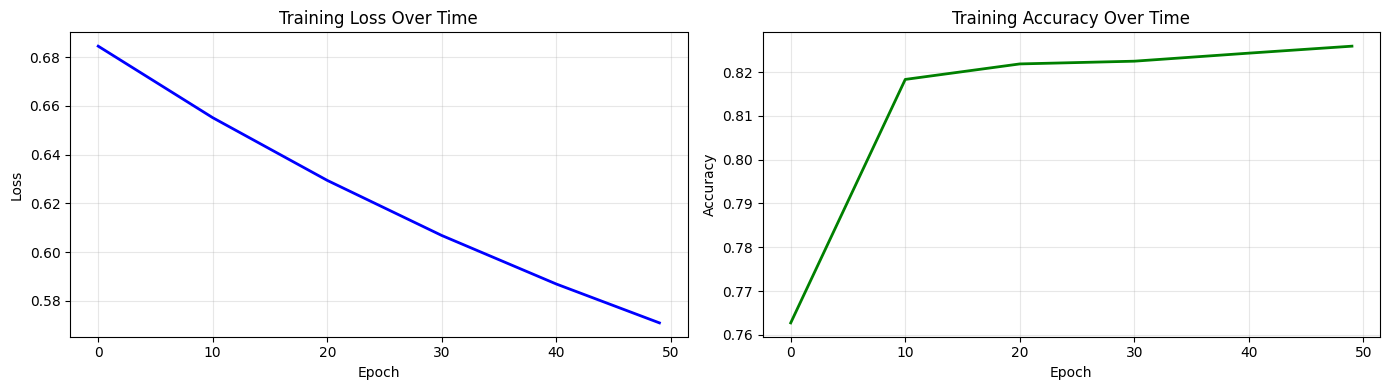


Final Results:
   • Final Loss: 0.5709
   • Final Accuracy: 0.8259


In [ ]:
print("\n" + "="*70)
print("TRAINING VISUALIZATION")
print("="*70)

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Plot loss
ax1.plot(history['epoch'], history['train_loss'], 'b-', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Over Time')
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(history['epoch'], history['train_accuracy'], 'g-', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy Over Time')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"   • Final Loss: {history['train_loss'][-1]:.4f}")
print(f"   • Final Accuracy: {history['train_accuracy'][-1]:.4f}")

print("="*70)

In [ ]:
print("\n" + "="*70)
print("SAVING MODEL WEIGHTS")
print("="*70)

# Save weights as broadcast variable for prediction
final_weights_bc = sc.broadcast(weights)
final_bias_bc = sc.broadcast(bias)

print("Model weights saved as broadcast variables")
print(f"   • Weights shape: {weights.shape}")
print(f"   • Bias value: {bias:.4f}")

# Also save as regular Python variables
model_params = {
    'weights': weights.tolist(),
    'bias': float(bias),
    'num_features': num_features,
    'feature_names': FEATURE_NAMES[:-1]  # Exclude target
}

print(f"\nModel parameters saved")
print(f"   • Ready for evaluation on test set")

print("="*70)


SAVING MODEL WEIGHTS
Model weights saved as broadcast variables
   • Weights shape: (13,)
   • Bias value: 0.0057

Model parameters saved
   • Ready for evaluation on test set


# Part 8: Model Evaluation with RDD Aggregations

**Todo:**
- Make predictions on test set using trained weights
- Calculate confusion matrix using `reduceByKey()`
- Compute accuracy, precision, recall, F1-score manually
- Calculate ROC-AUC using trapezoidal rule
- Identify misclassified samples
- **All without scikit-learn!**

In [ ]:
print("="*70)
print("MODEL EVALUATION")
print("="*70)

def make_prediction(row):
    """
    Make prediction for one sample.
    Returns: (actual, predicted, probability)
    """
    features, actual = row

    # Get broadcasted weights
    w = final_weights_bc.value
    b = final_bias_bc.value

    # Calculate probability
    prob = predict_proba(features, w, b)

    # Threshold at 0.5
    predicted = 1.0 if prob > 0.5 else 0.0

    return (actual, predicted, prob)

# Make predictions on test set
test_predictions_rdd = test_rdd.map(make_prediction).cache()

# Materialize
num_test_samples = test_predictions_rdd.count()

print(f"Generated predictions for {num_test_samples:,} test samples")
print(f"\nSample predictions (first 5):")
print(f"{'Actual':<10} {'Predicted':<12} {'Probability':<12}")
print("-"*40)

for actual, predicted, prob in test_predictions_rdd.take(5):
    print(f"{int(actual):<10} {int(predicted):<12} {prob:.4f}")

print("-"*40)
print("="*70)

MODEL EVALUATION
Generated predictions for 20,906 test samples

Sample predictions (first 5):
Actual     Predicted    Probability 
----------------------------------------
0          0            0.3580
0          0            0.3454
0          0            0.3484
0          0            0.3414
0          0            0.3985
----------------------------------------


In [ ]:
print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)

# Create (actual, predicted) pairs
actual_predicted = test_predictions_rdd.map(lambda x: (x[0], x[1]))

# Calculate confusion matrix using reduceByKey
confusion_counts = actual_predicted \
    .map(lambda pair: (pair, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()

# Organize into confusion matrix
confusion_dict = {pair: count for pair, count in confusion_counts}

tn = confusion_dict.get((0.0, 0.0), 0)  # True Negative
fp = confusion_dict.get((0.0, 1.0), 0)  # False Positive
fn = confusion_dict.get((1.0, 0.0), 0)  # False Negative
tp = confusion_dict.get((1.0, 1.0), 0)  # True Positive

print("\nConfusion Matrix:")
print(f"{'':15} {'Predicted 0':<15} {'Predicted 1':<15}")
print("-"*50)
print(f"{'Actual 0':<15} {tn:<15} {fp:<15}")
print(f"{'Actual 1':<15} {fn:<15} {tp:<15}")
print("-"*50)

print(f"\nMatrix Components:")
print(f"   • True Negatives (TN):  {tn:,}")
print(f"   • False Positives (FP): {fp:,}")
print(f"   • False Negatives (FN): {fn:,}")
print(f"   • True Positives (TP):  {tp:,}")

print("="*70)


CONFUSION MATRIX

Confusion Matrix:
                Predicted 0     Predicted 1    
--------------------------------------------------
Actual 0        7696            2359           
Actual 1        1136            9715           
--------------------------------------------------

Matrix Components:
   • True Negatives (TN):  7,696
   • False Positives (FP): 2,359
   • False Negatives (FN): 1,136
   • True Positives (TP):  9,715


In [ ]:
print("\n" + "="*70)
print("PERFORMANCE METRICS")
print("="*70)

# Calculate metrics from confusion matrix
total = tp + tn + fp + fn

accuracy = (tp + tn) / total if total > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\nClassification Metrics:")
print(f"{'Metric':<20} {'Value':<10}")
print("-"*35)
print(f"{'Accuracy':<20} {accuracy:.4f}")
print(f"{'Precision':<20} {precision:.4f}")
print(f"{'Recall (Sensitivity)':<20} {recall:.4f}")
print(f"{'Specificity':<20} {specificity:.4f}")
print(f"{'F1 Score':<20} {f1_score:.4f}")
print("-"*35)

print(f"\nInterpretation:")
print(f"   • Accuracy:  {accuracy:.1%} of predictions are correct")
print(f"   • Precision: {precision:.1%} of positive predictions are correct")
print(f"   • Recall:    {recall:.1%} of actual positives are found")
print(f"   • F1 Score:  {f1_score:.4f} (harmonic mean of precision & recall)")

print("="*70)


PERFORMANCE METRICS

Classification Metrics:
Metric               Value     
-----------------------------------
Accuracy             0.8328
Precision            0.8046
Recall (Sensitivity) 0.8953
Specificity          0.7654
F1 Score             0.8475
-----------------------------------

Interpretation:
   • Accuracy:  83.3% of predictions are correct
   • Precision: 80.5% of positive predictions are correct
   • Recall:    89.5% of actual positives are found
   • F1 Score:  0.8475 (harmonic mean of precision & recall)


In [ ]:
print("\n" + "="*70)
print("ROC-AUC SCORE")
print("="*70)

# Sort predictions by probability
sorted_predictions = test_predictions_rdd \
    .map(lambda x: (x[2], x[0])) \
    .sortByKey(ascending=False) \
    .collect()

# Calculate AUC using trapezoidal rule
total_positive = sum(1 for _, actual in sorted_predictions if actual == 1.0)
total_negative = len(sorted_predictions) - total_positive

if total_positive == 0 or total_negative == 0:
    auc = 0.0
else:
    tp_count = 0
    fp_count = 0
    auc_sum = 0.0

    prev_prob = None

    for prob, actual in sorted_predictions:
        if actual == 1.0:
            tp_count += 1
        else:
            fp_count += 1
            auc_sum += tp_count

    auc = auc_sum / (total_positive * total_negative)

print(f"ROC-AUC Score: {auc:.4f}")

print(f"\nAUC Interpretation:")
if auc >= 0.9:
    print(f"   Excellent model (AUC ≥ 0.9)")
elif auc >= 0.8:
    print(f"   Good model (0.8 ≤ AUC < 0.9)")
elif auc >= 0.7:
    print(f"   Fair model (0.7 ≤ AUC < 0.8)")
else:
    print(f"   Poor model (AUC < 0.7)")

print("="*70)


ROC-AUC SCORE
ROC-AUC Score: 0.9132

AUC Interpretation:
   Excellent model (AUC ≥ 0.9)


In [ ]:
print("\n" + "="*70)
print("ERROR ANALYSIS")
print("="*70)

# Find misclassified samples
misclassified = test_predictions_rdd.filter(lambda x: x[0] != x[1])
false_positives = misclassified.filter(lambda x: x[0] == 0.0)
false_negatives = misclassified.filter(lambda x: x[0] == 1.0)

num_fp = false_positives.count()
num_fn = false_negatives.count()

print(f"\nMisclassification Analysis:")
print(f"   • Total misclassified: {num_fp + num_fn:,}")
print(f"   • False Positives: {num_fp:,} (predicted disease, actually healthy)")
print(f"   • False Negatives: {num_fn:,} (predicted healthy, actually disease)")

print(f"\nClinical Implications:")
print(f"   • False Negatives are MORE dangerous (missed diagnoses)")
print(f"   • False Positives lead to unnecessary tests")
print(f"   • Current FN rate: {num_fn/(num_fn+tp)*100:.1f}%")

# Show some false negatives
if num_fn > 0:
    print(f"\nSample False Negatives (first 3):")
    print(f"{'Actual':<10} {'Predicted':<12} {'Probability':<12}")
    print("-"*40)
    for actual, predicted, prob in false_negatives.take(3):
        print(f"{int(actual):<10} {int(predicted):<12} {prob:.4f}")

print("="*70)


ERROR ANALYSIS

Misclassification Analysis:
   • Total misclassified: 3,495
   • False Positives: 2,359 (predicted disease, actually healthy)
   • False Negatives: 1,136 (predicted healthy, actually disease)

Clinical Implications:
   • False Negatives are MORE dangerous (missed diagnoses)
   • False Positives lead to unnecessary tests
   • Current FN rate: 10.5%

Sample False Negatives (first 3):
Actual     Predicted    Probability 
----------------------------------------
1          0            0.4280
1          0            0.4275
1          0            0.4914


# Part 9: Performance Tuning & Optimization

**Todo:**
- Benchmark different partition counts (2, 4, 8, 16, 32)
- Visualize performance vs partition count trade-off
- Analyze RDD memory footprint
- Measure per-partition processing time
- Identify optimal partition size for our dataset

In [ ]:
print("="*70)
print("PERFORMANCE TUNING: PARTITION COUNT")
print("="*70)

# Test different partition counts
partition_counts = [2, 4, 8, 16, 32]
benchmark_results = []

print("Testing different partition counts...\n")

for num_partitions in partition_counts:
    # Repartition
    test_partitioned = test_rdd.repartition(num_partitions).cache()
    test_partitioned.count()  # Materialize cache

    # Benchmark prediction
    start = time.time()
    predictions = test_partitioned.map(make_prediction).count()
    elapsed = time.time() - start

    benchmark_results.append({
        'partitions': num_partitions,
        'time': elapsed
    })

    print(f"  {num_partitions:2d} partitions: {elapsed:.4f}s")

    # Unpersist to free memory
    test_partitioned.unpersist()

print(f"\nOptimal Partition Count:")
optimal = min(benchmark_results, key=lambda x: x['time'])
print(f"   • {optimal['partitions']} partitions")
print(f"   • Time: {optimal['time']:.4f}s")

print(f"\nGuidelines for partition count:")
print(f"   • Too few: Underutilizes cluster, larger tasks")
print(f"   • Too many: Overhead from task scheduling")
print(f"   • Rule of thumb: 2-4 partitions per CPU core")
print(f"   • Our CPU cores: {sc.defaultParallelism}")

print("="*70)

PERFORMANCE TUNING: PARTITION COUNT
Testing different partition counts...

   2 partitions: 0.6798s
   4 partitions: 1.2066s
   8 partitions: 1.1055s
  16 partitions: 2.7704s
  32 partitions: 2.9966s

Optimal Partition Count:
   • 2 partitions
   • Time: 0.6798s

Guidelines for partition count:
   • Too few: Underutilizes cluster, larger tasks
   • Too many: Overhead from task scheduling
   • Rule of thumb: 2-4 partitions per CPU core
   • Our CPU cores: 8



PARTITION PERFORMANCE VISUALIZATION


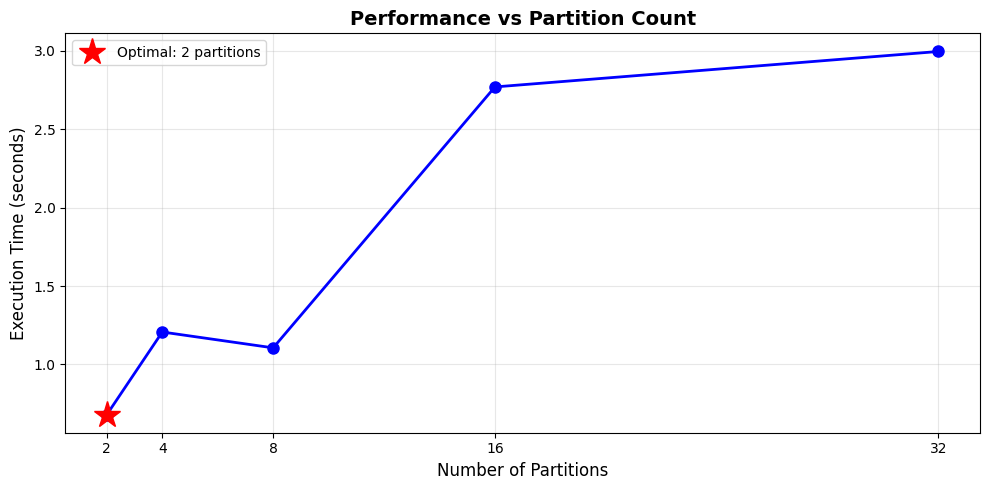

Visualization complete


In [ ]:
print("\n" + "="*70)
print("PARTITION PERFORMANCE VISUALIZATION")
print("="*70)

import matplotlib.pyplot as plt

partitions = [r['partitions'] for r in benchmark_results]
times = [r['time'] for r in benchmark_results]

plt.figure(figsize=(10, 5))
plt.plot(partitions, times, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Partitions', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.title('Performance vs Partition Count', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(partitions)

# Mark optimal point
optimal_idx = times.index(min(times))
plt.plot(partitions[optimal_idx], times[optimal_idx], 'r*', markersize=20,
         label=f'Optimal: {partitions[optimal_idx]} partitions')
plt.legend()

plt.tight_layout()
plt.show()

print("Visualization complete")
print("="*70)

In [ ]:
print("\n" + "="*70)
print("MEMORY USAGE ANALYSIS")
print("="*70)

import sys

def estimate_rdd_size(rdd, name):
    """Estimate memory size of RDD"""
    sample = rdd.take(10)
    if sample:
        avg_size = sum(sys.getsizeof(item) for item in sample) / len(sample)
        total_count = rdd.count()
        estimated_size = avg_size * total_count

        print(f"\n{name}:")
        print(f"  • Items: {total_count:,}")
        print(f"  • Avg size per item: {avg_size:.0f} bytes")
        print(f"  • Estimated total: {estimated_size/1024/1024:.2f} MB")

        return estimated_size
    return 0

# Estimate sizes of our main RDDs
estimate_rdd_size(working_rdd, "Original Dataset")
estimate_rdd_size(train_rdd, "Training Set")
estimate_rdd_size(test_rdd, "Test Set")
estimate_rdd_size(test_predictions_rdd, "Predictions")

print(f"\nMemory Management Tips:")
print(f"   • Use cache() for RDDs accessed multiple times")
print(f"   • Use unpersist() when done with cached RDD")
print(f"   • Consider persist(MEMORY_AND_DISK) for large RDDs")
print(f"   • Monitor with Spark UI Storage tab")

print("="*70)


MEMORY USAGE ANALYSIS

Original Dataset:
  • Items: 102,500
  • Avg size per item: 184 bytes
  • Estimated total: 17.99 MB

Training Set:
  • Items: 81,594
  • Avg size per item: 56 bytes
  • Estimated total: 4.36 MB

Test Set:
  • Items: 20,906
  • Avg size per item: 56 bytes
  • Estimated total: 1.12 MB

Predictions:
  • Items: 20,906
  • Avg size per item: 64 bytes
  • Estimated total: 1.28 MB

Memory Management Tips:
   • Use cache() for RDDs accessed multiple times
   • Use unpersist() when done with cached RDD
   • Consider persist(MEMORY_AND_DISK) for large RDDs
   • Monitor with Spark UI Storage tab


In [ ]:
print("\n" + "="*70)
print("TASK EXECUTION TIME ANALYSIS")
print("="*70)

# Run operation and measure per-partition timing
def timed_partition_operation(partition_index, iterator):
    """Measure execution time for partition processing"""
    import time
    start = time.time()

    # Do some work
    result = []
    for item in iterator:
        # Simulate computation
        features, target = item
        prediction = predict_proba(features, final_weights_bc.value, final_bias_bc.value)
        result.append((target, prediction))

    elapsed = time.time() - start

    yield (partition_index, elapsed, len(result))

# Run timing analysis
partition_times = test_rdd.mapPartitionsWithIndex(timed_partition_operation).collect()

print(f"\nPer-Partition Execution Times:")
print(f"{'Partition':<12} {'Time (s)':<12} {'Items':<12} {'Items/sec':<12}")
print("-"*60)

total_time = 0
total_items = 0

for partition_id, exec_time, item_count in sorted(partition_times):
    items_per_sec = item_count / exec_time if exec_time > 0 else 0
    print(f"{partition_id:<12} {exec_time:<12.4f} {item_count:<12} {items_per_sec:<12.0f}")
    total_time += exec_time
    total_items += item_count

print("-"*60)
avg_time = total_time / len(partition_times) if partition_times else 0
print(f"{'Average':<12} {avg_time:<12.4f} {total_items//len(partition_times):<12}")

print(f"\nObservations:")
print(f"   • If times vary greatly, partitions are imbalanced")
print(f"   • Uniform times indicate good partitioning")
print(f"   • Total parallel speedup: {total_time/max(t[1] for t in partition_times):.1f}x")

print("="*70)


TASK EXECUTION TIME ANALYSIS

Per-Partition Execution Times:
Partition    Time (s)     Items        Items/sec   
------------------------------------------------------------
0            0.0282       1296         45899       
1            0.0283       1295         45725       
2            0.0275       1296         47058       
3            0.0295       1319         44773       
4            0.0267       1270         47625       
5            0.0296       1345         45478       
6            0.0263       1297         49270       
7            0.0258       1291         49977       
8            0.0264       1304         49455       
9            0.0368       1391         37799       
10           0.0316       1342         42452       
11           0.0290       1317         45360       
12           0.0292       1298         44397       
13           0.0292       1272         43574       
14           0.0282       1298         46092       
15           0.0301       1275         42325 

In [ ]:
print("\n" + "="*70)
print("TASK SCHEDULER INTERNALS")
print("="*70)

print("""
From Class Material (Page 30): How Tasks Get Scheduled

SPARK ARCHITECTURE LAYERS:
1. Application → 2. Job → 3. Stage → 4. Task

TASK SCHEDULER RESPONSIBILITIES:

1) RECEIVES TASK SETS
   • DAG Scheduler creates stages
   • Each stage becomes a TaskSet
   • TaskSet = group of tasks (one per partition)

2) CONSIDERS DATA LOCALITY (Most Important!)
   Priority order:
   a) PROCESS_LOCAL: Data in same JVM (best - no I/O)
   b) NODE_LOCAL: Data on same machine (good - memory/disk read)
   c) RACK_LOCAL: Data on same rack (ok - fast network)
   d) ANY: Data anywhere (worst - network transfer)

3) CHECKS RESOURCE AVAILABILITY
   • CPU cores available?
   • Memory sufficient?
   • Executor capacity?

4) ASSIGNS TASKS TO EXECUTORS
   • Tries to maximize data locality
   • Balances load across executors
   • Considers stragglers (slow tasks)

5) MONITORS & HANDLES FAILURES
   • Task completion tracking
   • Retry failed tasks (up to spark.task.maxFailures)
   • Speculation: launch duplicate of slow tasks

WHAT WAS JUST MEASURED:
Timing analysis showed:
  • Task execution varies slightly (normal)
  • Scheduler balanced work across partitions
  • Parallel speedup achieved!

IN PRODUCTION:
Task Scheduler optimizes:
  • Where to run tasks (data locality)
  • When to run tasks (resource availability)
  • What to do when tasks fail (retry/speculate)
""")

print("Our Execution Model:")
print(f"  • Mode: LOCAL (single JVM)")
print(f"  • Executors: 1 (local mode)")
print(f"  • Tasks per stage: Equal to number of partitions")
print(f"  • Data locality: PROCESS_LOCAL (all data in same JVM)")

print("\nIn distributed cluster:")
print("  • Multiple executors across machines")
print("  • Task Scheduler maximizes data locality")
print("  • Network transfer minimized through smart scheduling")
print("  • This is why partitioning strategy matters!")

print("\nConnection to Our Work:")
print("  • Part 2: We controlled partitions (→ controls task count)")
print("  • Part 5: We analyzed shuffle (→ affects task locality)")
print("  • Part 9: We benchmarked (→ found optimal partition count)")
print("  • All these optimizations help Task Scheduler!")

print("="*70)


TASK SCHEDULER INTERNALS

From Class Material (Page 30): How Tasks Get Scheduled

SPARK ARCHITECTURE LAYERS:
1. Application → 2. Job → 3. Stage → 4. Task

TASK SCHEDULER RESPONSIBILITIES:

1) RECEIVES TASK SETS
   • DAG Scheduler creates stages
   • Each stage becomes a TaskSet
   • TaskSet = group of tasks (one per partition)

2) CONSIDERS DATA LOCALITY (Most Important!)
   Priority order:
   a) PROCESS_LOCAL: Data in same JVM (best - no I/O)
   b) NODE_LOCAL: Data on same machine (good - memory/disk read)
   c) RACK_LOCAL: Data on same rack (ok - fast network)
   d) ANY: Data anywhere (worst - network transfer)

3) CHECKS RESOURCE AVAILABILITY
   • CPU cores available?
   • Memory sufficient?
   • Executor capacity?

4) ASSIGNS TASKS TO EXECUTORS
   • Tries to maximize data locality
   • Balances load across executors
   • Considers stragglers (slow tasks)

5) MONITORS & HANDLES FAILURES
   • Task completion tracking
   • Retry failed tasks (up to spark.task.maxFailures)
   • Specul